In [181]:
import torch.nn as nn
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [184]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../torchvision_data", train=True, transform=trans, download = True)
dtloader = DataLoader(mnist_train, batch_size = 256)

In [186]:
device = torch.device("cuda")

In [188]:
class VAE(nn.Module):
    """ 变分自编码器 """
    def __init__(self, input_size=784, hidden_size=256, latent_size=32):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                     nn.Linear(hidden_size, hidden_size//2),
                                    nn.ReLU())

        # 计算latent space的均值和对数方差
        self.fc_mu = nn.Linear(hidden_size//2, latent_size)
        self.fc_logvar = nn.Linear(hidden_size//2, latent_size)

        # decoder
        self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size//2),
                                     nn.ReLU(),
                                     nn.Linear(hidden_size//2, hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(hidden_size, input_size),
                                     nn.Sigmoid())

    def reparameterize(self, mu, logvar):
        """ 重新参数化方法 """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """ 前向传播 """
        # encoding
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        # reparameterize
        z = self.reparameterize(mu, logvar)
        # decoding
        x_recon = self.decoder(z)
        return x_recon, mu, logvar



In [222]:
def vae_loss(x_recon, x, mu, logvar):
    """ 自定义损失函数，用于描述重建损失 """
    BCE = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction="sum")

    
    KLD=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return BCE+KLD

In [224]:
model = VAE().to(device)
loss_func = vae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = dtloader

In [228]:
def train_model(model, dataloader, loss_func, optimizer):
    model.train()
    total_loss = 0
    for x, _ in dataloader: 
        x_recon, mu, logvar = model(x.view(-1, 784).to(device))
        loss = loss_func(x_recon, x.to(device), mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    return total_loss/len(dataloader)

In [235]:
n_epoch = 50

train_loss_list = []

for i in range(n_epoch):
    train_loss = train_model(model, dataloader, loss_func, optimizer)
    
    train_loss_list.append(train_loss)
    print(train_loss)
    

186.84965093085106
184.39469747340425
179.83543882978722
177.22659574468085
173.1760472074468
170.78641954787233
168.6597074468085
166.18081781914893
165.79905252659574
163.51319813829787
163.20777925531914
163.13191489361702
161.85620013297873
162.98520611702128
162.33425864361703
161.06771941489362
160.54840425531916
161.0356050531915
159.86198470744682
159.5607380319149
158.69858710106382
158.8498670212766
158.39122340425533
158.14842087765956
157.4704953457447
156.7826130319149
156.6505319148936
156.1994847074468
156.24261968085105
154.9710272606383
155.0216256648936
154.53051861702127
154.26740359042554
153.0063829787234
152.65679853723404
151.99165558510637
151.15889295212767
151.16648936170213
150.1859375
150.07548204787233
149.23578789893617
148.00078125
148.14157247340427
146.90161236702127
146.60262632978723
146.32930518617022
144.90136303191488
144.1558676861702
143.32834109042554
142.97470079787234


In [238]:
print(len(train_loss_list))

50


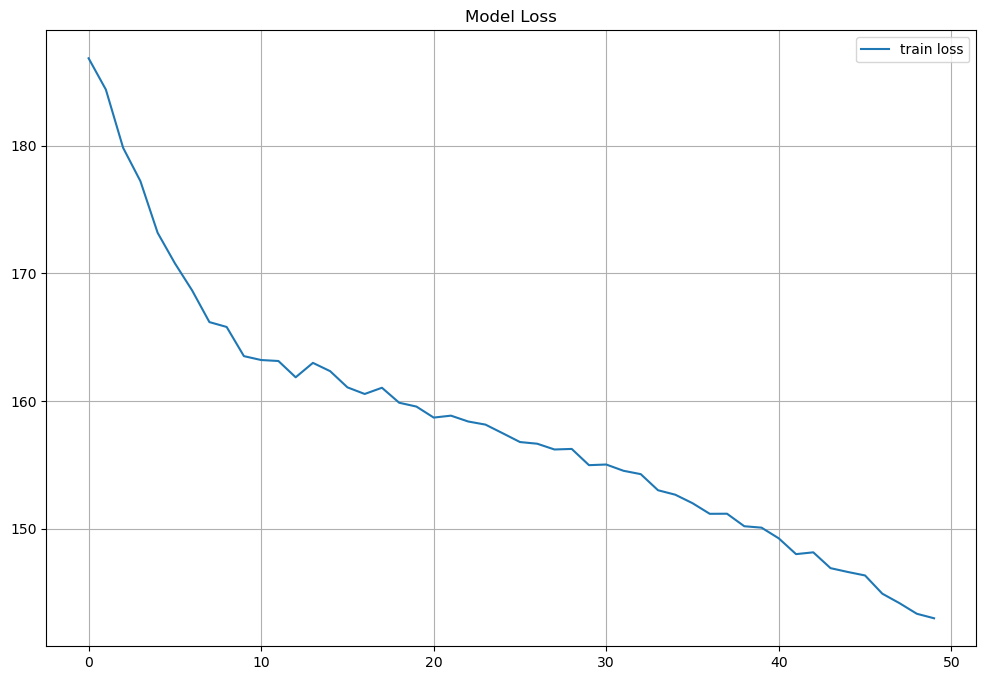

In [244]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(train_loss_list, label="train loss")
plt.title("Model Loss")
plt.grid()
plt.legend()
plt.show()